# Custom codes for Han et al. (2025). 

This jupyter notebook generates all of the display items in Han et al. (2025). _Estimating the global demand and potential public health impact of oral antiviral treatment stockpile for influenza pandemics: a mathematical modelling study_

## import libraries


In [1]:
import os
import re
import string
import pandas as pd 
import numpy as np 
import sciris as sc 
import scipy.stats as st 
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "Arial"
import matplotlib.colors as mpl_colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from zipfile import ZipFile
from scipy.stats import gaussian_kde
from sklearn.metrics import auc
import multiprocess as mp
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

## parameters

In [2]:
# models 
vl_to_inf_models = ["hill", "negexp", "logit"] 
# pandemic list 
pandemic_list = ["pandemic1918", "pandemic1968", "pandemic2009", "covid"]
# countries to region map 
country_list = ['USA', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRI', 'PRK', 'PRT', 'PRY', 'PSE', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SRB', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 'TKM', 'TLS', 'TON', 'TTO', 'TUN', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR', 'URY', 'UZB', 'VCT', 'VEN', 'VNM', 'VUT', 'WSM', 'YEM', 'ZAF', 'ZMB', 'ZWE']
country_to_region = pd.read_csv("../data/country_iso_codes.csv", keep_default_na=False)[["alpha-3", "continent_region"]].set_index("alpha-3")
country_to_region = country_to_region[country_to_region.index.isin(country_list)]

## functions

In [3]:
class analyze():
    def __init__(self, zf, fpath): 
        output = self.read_zip_output(zf, fpath) 
        
        # population 
        self.N = output.demography.sum() 
        self.demography = output.demography
        A = self.demography.shape[0]
        
        # get incidence 
        n_period = output.infected.shape[0] 
        self.incidence = np.zeros((n_period, 3), dtype=np.int32) # (n_period x (wt, emergent mt, transmitted mt))
        self.incidence[:,0] = output.infected.reshape((n_period, -1)).sum(axis=-1) # wild-type (drug sensitive) 
        for i in range(2): 
            # 0 = treatment-emergent mt incidence, 1 = transmitted mt incidence 
            self.incidence[:,i+1] = output.primary_mut_infected_n[i].reshape((366, -1)).sum(axis=-1)
        
        # get hospitalized (n_period x treatment group (untreated, BXM, OSL) x age categories) 
        self.daily_hospitalized = output.hospitalized
        
        # get deaths (n_period x age categories) 
        self.daily_deaths = output.deaths
        
        # testing 
        self.daily_tested = np.zeros((n_period, 2), dtype=np.int32) # (n_period x (wt, transmitted mt))
        self.daily_tested[:,0] = output.infected[:,1].reshape((n_period,-1)).sum(axis=-1)
        self.daily_tested[:,1] = output.primary_mut_infected_n[1][:,1].reshape((n_period,-1)).sum(axis=-1)
        
        # treatment 
        # (n_period x (TAT, PEP) x (drug sensitive, resistant, uninfected) x (BXM, OSL) x (age categories))
        self.daily_treated = np.zeros((n_period, 2, 3, 2, A), dtype=np.int32) 
        # TAT x wt x BXM
        self.daily_treated[:,0,0,0] = output.treatment[:,0,0,1]
        # PEP x wt x BXM 
        self.daily_treated[:,1,0,0] = output.treatment[:,1,0,1]
        # TAT x wt x OSL 
        self.daily_treated[:,0,0,1] = output.treatment[:,0,1,1]
        # PEP x wt x OSL 
        self.daily_treated[:,1,0,1] = output.treatment[:,1,1,1]
        # TAT x mt x BXM
        self.daily_treated[:,0,1,0] = output.treatment[:,0,0,2]
        # PEP x mt x BXM 
        self.daily_treated[:,1,1,0] = output.treatment[:,1,0,2]
        # TAT x mt x OSL 
        self.daily_treated[:,0,1,1] = output.treatment[:,0,1,2]
        # PEP x mt x OSL 
        self.daily_treated[:,1,1,1] = output.treatment[:,1,1,2]
        # PEP x uninfected x BXM 
        self.daily_treated[:,1,2,0] = output.treatment[:,1,0,0]
        # PEP x uninfected x OSL 
        self.daily_treated[:,1,2,1] = output.treatment[:,1,1,0]
        
    def compute_weekly_counts(self, daily_counts):
        # compute weekly counts 
        weekly_counts = np.zeros(int(daily_counts.size/7))
        for w, d in enumerate(np.arange(8, daily_counts.size, 7)):
            weekly_counts[w] = daily_counts[d-7:d].sum()
        return weekly_counts

    def read_zip_output(self, zf, fpath):
        core_files = ['demography.npz', 'infected.npz', 'primary_mut_infected_n.npz', 'treatment.npz', 'hospitalized.npz', 'deaths.npz']
        output = sc.objdict()
        for f in core_files: 
            flabel = f.replace(".npz", "")
            with zf.open(fpath + f) as z: 
                output[flabel] = np.load(z)['arr']
        return output

def extract_results_from_zipfile(fpath, model=None): 
    """
    parse through zip file folders to extract results 
    """
    df = []
    
    with ZipFile(fpath, 'r') as zf:
        for foldername in zf.namelist():
            # find results folder 
            try: 
                zf.open(foldername + "deaths.npz")
            except: 
                continue 
            # read results folder 
            output_obj = analyze(zf, foldername)
            # get country and pandemic  
            country, pandemic = re.search("(" + "|".join(country_list) + ")_(" + "|".join(pandemic_list) + ")", foldername).group().split("_")
            # get region 
            region = country_to_region.loc[country, "continent_region"]#.lower().replace(" ", "_")
            # get model 
            try: 
                model = re.search("(" + "|".join(vl_to_inf_models) + ")", foldername).group()
            except: 
                pass 
            
            row_dict = {"model":model, "region":region, "country":country, "pandemic":pandemic}
            
            # get test sensitivity 
            try: 
                TS = int(re.search("TS([0-9]+)", foldername).group(1))
                row_dict['baseline'] = 0
            except: 
                row_dict['baseline'] = 1

            if row_dict["baseline"] == 0: 
                # extract treatment initiation day 
                row_dict["AVS"] = int(re.search("AVS([0-9]+)", foldername).group(1))
                # extract non-baseline parameters 
                row_dict['TS'] = TS
                row_dict["TW"] = int(re.search("TW([0-9]+)", foldername).group(1))
                if re.search("PEP", foldername): 
                    row_dict["PEP"] = 1
                else: 
                    row_dict["PEP"] = 0
                # get average delay to TAT since symptom onset and treatment 
                tat_delay = int(re.search("_(1|2|5)D_", foldername).group(1))
                if tat_delay == 2: 
                    row_dict["tat_delay"] = 3
                elif tat_delay == 5: 
                    row_dict["tat_delay"] = 7 
                else: 
                    row_dict["tat_delay"] = 1
                # treatment 
                treatment = re.search("(BXM[0-9][0-9]-[0-9][0-9]|BXM|OSL)", foldername).group()
                row_dict["treatment"] = treatment
                # with or without resistance 
                if re.search("H3RESIST", foldername): 
                    row_dict["bxm_resistance"] = 2
                elif re.search("H1RESIST", foldername): 
                    row_dict["bxm_resistance"] = 1
                else: 
                    row_dict["bxm_resistance"] = 0
                # treatment window 
                row_dict["treat_window"] = int(re.search("WIN([0-9]+)", foldername).group(1))

            # read output 
            row_dict["pop_N"] = output_obj.N
            # get number of incidence and deaths 
            row_dict["n_wt"] = output_obj.incidence[:,0].sum()
            row_dict["n_emerge_mt"] = output_obj.incidence[:,1].sum()
            row_dict["n_trans_mt"] = output_obj.incidence[:,2].sum()
            row_dict["n_deaths"] = output_obj.daily_deaths.sum()
            # get minimum testing needed 
            row_dict['n_test'] = output_obj.daily_tested.sum()
            # get number of treatments needed for tat  
            row_dict['n_treatment_tat'] = output_obj.daily_treated[:,0].sum()
            row_dict['n_treatment_pep'] = output_obj.daily_treated[:,1].sum()
            if output_obj.daily_treated[:,1].sum() < 0: 
                print (output_obj.daily_treated[:,1].sum(axis=0))

            df.append(row_dict)
            
    df = pd.DataFrame.from_dict(df)
    return df 

## read simulation result files

In [4]:
try: 
    tat_stockpile_df = pd.read_csv("../manuscript/tat_stockpile_df.csv")
    tat_stockpile_df['region'] = tat_stockpile_df['region'].fillna("NA")
except: 
    tat_stockpile_df = []
    for root, dirs, files in os.walk("../simulations/hill"): 
        for file in files: 
            if re.search(".zip", file): 
                fpath = root + "/" + file
                #print (fpath)
                csv_fpath = root + "/" + file.replace(".zip", "") + ".csv"
                try: 
                    df = pd.read_csv(csv_fpath, keep_default_na=False)
                except:
                    model = re.search("(" + "|".join(vl_to_inf_models) + ")", fpath).group()
                    df = extract_results_from_zipfile(fpath, model=model)
                    df.to_csv(csv_fpath, index=False)
                tat_stockpile_df.append(df)
    
    tat_stockpile_df = pd.concat(tat_stockpile_df, ignore_index=True)
    tat_stockpile_df['n_incidence'] = tat_stockpile_df['n_wt'] + tat_stockpile_df['n_trans_mt']
    tat_stockpile_df['n_treatment'] = tat_stockpile_df['n_treatment_tat'] + tat_stockpile_df['n_treatment_pep']
    tat_stockpile_df['f_treatment'] = tat_stockpile_df['n_treatment']/tat_stockpile_df['pop_N']
    tat_stockpile_df.to_csv("../manuscript/tat_stockpile_df.csv", index=False)
    
tat_stockpile_df.head()

,model,region,country,pandemic,baseline,AVS,TS,TW,PEP,tat_delay,...,n_wt,n_emerge_mt,n_trans_mt,n_deaths,n_test,n_treatment_tat,n_treatment_pep,n_incidence,n_treatment,f_treatment
0,hill,NA,USA,pandemic1918,0,7.0,70.0,100.0,0.0,3.0,...,129712064,1577917,62395519,1490425,117394814,78189233,0,192107583,78189233,0.232017
1,hill,NA,USA,pandemic1918,0,7.0,70.0,100.0,0.0,1.0,...,19830595,853339,187272949,1976508,131989539,92392546,0,207103544,92392546,0.274164
2,hill,NA,USA,pandemic1918,0,7.0,70.0,100.0,0.0,1.0,...,19845323,853109,187256363,1976510,131988369,92289700,0,207101686,92289700,0.273859
3,hill,NA,USA,pandemic1918,0,7.0,70.0,100.0,0.0,1.0,...,62968623,840312,136503966,1754726,127126161,88889910,0,199472589,88889910,0.263770
4,hill,NA,USA,pandemic1918,0,7.0,70.0,100.0,0.0,1.0,...,62941344,840785,136534034,1754637,127127971,88989401,0,199475378,88989401,0.264065


## Figure 1: Mean percentage deaths averted by test-and-treat with oral antivirals in 186 countries. 

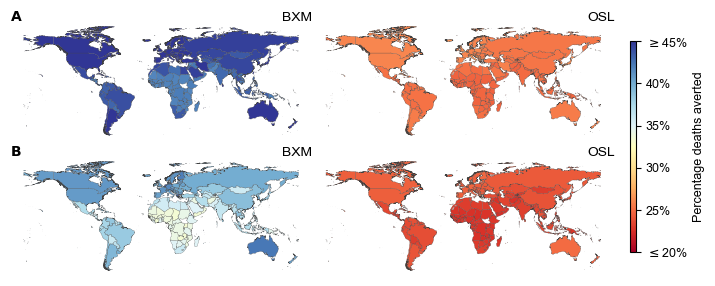

In [5]:
baseline_df = tat_stockpile_df[tat_stockpile_df['baseline']==1]

world = gpd.read_file('../data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
world = world[(world.SOVEREIGNT!="Antarctica")]
common_countries = list(set(world['ADM0_A3'])&set(baseline_df['country']))
world = world[world["ADM0_A3"].isin(common_countries)]

# compute deaths averted per million individuals 
vmin, vmax = 1e9, -1e9
cumm_arr = []
plot_df = tat_stockpile_df[(tat_stockpile_df['baseline']==0.)&(tat_stockpile_df['PEP']==0.)&(tat_stockpile_df['treat_window']==2.)&(tat_stockpile_df['bxm_resistance']==0.)&(tat_stockpile_df['tat_delay']==1.)&(tat_stockpile_df['AVS']==7.)].copy()
for i, pandemic in enumerate(["pandemic1918", "covid"]): 
    curr_baseline_df = baseline_df[baseline_df['pandemic']==pandemic].copy().set_index("country")
    for j, treatment in enumerate(['BXM', 'OSL']):
        curr_plot_df = plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)].copy()
        # get baseline deaths 
        curr_plot_df["baseline_deaths"] = curr_plot_df["country"].map(curr_baseline_df["n_deaths"]).to_numpy()
        # compute deaths averted per 100K individuals 
        curr_plot_df["dea_averted_perc"] = 100 * (curr_plot_df["baseline_deaths"]-curr_plot_df["n_deaths"])/curr_plot_df['baseline_deaths']
        curr_plot_df = curr_plot_df.set_index("country")
        cumm_arr += list(curr_plot_df["dea_averted_perc"])
        # map to world 
        world['dea_averted_perc_%s-%s'%(pandemic, treatment)] = world['ADM0_A3'].map(curr_plot_df['dea_averted_perc'])
        if world['dea_averted_perc_%s-%s'%(pandemic, treatment)].min() < vmin: 
            vmin = world['dea_averted_perc_%s-%s'%(pandemic, treatment)].min()
        if world['dea_averted_perc_%s-%s'%(pandemic, treatment)].max() > vmax: 
            vmax = world['dea_averted_perc_%s-%s'%(pandemic, treatment)].max()
#print (vmin, vmax)
#print (np.quantile(cumm_arr, 0.05), np.quantile(cumm_arr, 0.95))

vmin = 20. #np.floor(vmin/10)* 10
vmax = 45. #np.ceil(vmax/10)* 10

# plot 
fig = plt.figure(figsize=(7.8, 7.8*0.45))
gs = GridSpec(nrows=2, ncols=2, wspace=0., hspace=0.)

for i, treatment in enumerate(['BXM', 'OSL']):
    for j, pandemic in enumerate(["pandemic1918", "covid"]): 
    
        ax = fig.add_subplot(gs[j,i])
        p = world.plot(ax=ax, column='dea_averted_perc_%s-%s'%(pandemic, treatment), 
                       cmap="RdYlBu", vmin=vmin, vmax=vmax, #norm=norm,
                       edgecolor='#404040', linewidth=0.15,
                       legend=False)
        ax.axis("off")
        if i == 0:
            ax.text(x=0., y=1., s=r'$\bf{%s}$'%(list(string.ascii_uppercase)[j]), transform=ax.transAxes, fontsize=10)
            #print (list(string.ascii_uppercase)[i], pandemic)
        ax.text(x=1., y=1., s=treatment, fontsize=10, transform=ax.transAxes, ha='right')
            
cmap = mpl.cm.RdYlBu
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.2, 0.0075, 0.6])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,)
yticks_arr = np.arange(vmin, vmax+1, 5)
cbar_ax.set_yticks(yticks_arr)
cbar_ax.set_yticklabels([r"$\leq$%i%%"%(yticks_arr[0])] + ["%i%%"%(y) for y in yticks_arr[1:-1]] + [r"$\geq$%i%%"%(yticks_arr[-1])])
cbar_ax.tick_params(labelsize=9)
cbar_ax.set_ylabel("Percentage deaths averted", fontsize=9)
plt.savefig("../manuscript/figure001.png", bbox_inches='tight', dpi=600)
plt.show()

## Figure 2: Maximum mean treatment oral antiviral demand of 186 countries.

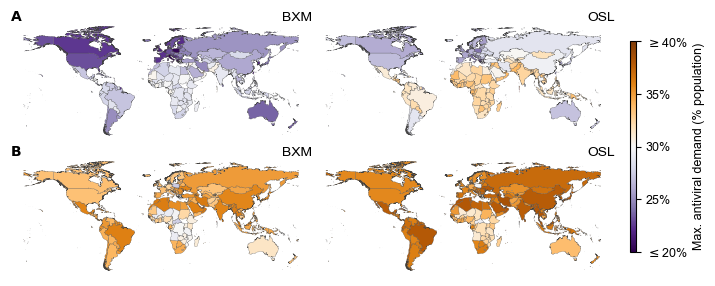

In [6]:
# compute deaths averted per million individuals 
vmin, vmax = 1e9, -1e9
cumm_arr = []
plot_df = tat_stockpile_df[(tat_stockpile_df['baseline']==0.)&(tat_stockpile_df['PEP']==0.)&(tat_stockpile_df['treat_window']==2.)&(tat_stockpile_df['bxm_resistance']==0.)&(tat_stockpile_df['tat_delay']==1.)&(tat_stockpile_df['AVS']==7.)].copy()
for i, pandemic in enumerate(["pandemic1918", "covid"]): 
    for j, treatment in enumerate(['BXM', 'OSL']):
        curr_plot_df = plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)].copy()
        # compute antiviral stockpile size 
        curr_plot_df["av_stockpile_size"] = 100 * curr_plot_df["f_treatment"]
        curr_plot_df = curr_plot_df.set_index("country")
        cumm_arr += list(curr_plot_df["av_stockpile_size"])
        # map to world 
        world['av_stockpile_%s-%s'%(pandemic, treatment)] = world['ADM0_A3'].map(curr_plot_df['av_stockpile_size'])
        if world['av_stockpile_%s-%s'%(pandemic, treatment)].min() < vmin: 
            vmin = world['av_stockpile_%s-%s'%(pandemic, treatment)].min()
        if world['av_stockpile_%s-%s'%(pandemic, treatment)].max() > vmax: 
            vmax = world['av_stockpile_%s-%s'%(pandemic, treatment)].max()
#print (vmin, vmax)
#print (np.quantile(cumm_arr, 0.05), np.quantile(cumm_arr, 0.95))
vmin = 20. #np.floor(vmin/10)* 10
vmax = 40. #np.ceil(vmax/10)* 10

# plot 
fig = plt.figure(figsize=(7.8, 7.8*0.45))
gs = GridSpec(nrows=2, ncols=2, wspace=0., hspace=0.)

for i, treatment in enumerate(['BXM', 'OSL']):
    for j, pandemic in enumerate(["pandemic1918", "covid"]): 
        ax = fig.add_subplot(gs[j,i])
        p = world.plot(ax=ax, column='av_stockpile_%s-%s'%(pandemic, treatment), 
                       cmap="PuOr_r", vmin=vmin, vmax=vmax, #norm=norm,
                       edgecolor='#404040', linewidth=0.15,
                       legend=False)
        ax.axis("off")
        if i == 0:
            ax.text(x=0., y=1., s=r'$\bf{%s}$'%(list(string.ascii_uppercase)[j]), transform=ax.transAxes, fontsize=10)
            #print (list(string.ascii_uppercase)[i], pandemic)
        ax.text(x=1., y=1., s=treatment, fontsize=10, transform=ax.transAxes, ha='right')
            
cmap = mpl.cm.PuOr_r
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.2, 0.0075, 0.6])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,)
cbar_ax.tick_params(labelsize=9)
yticks_arr = np.arange(vmin, vmax+1, 5)
cbar_ax.set_yticks(yticks_arr)
cbar_ax.set_yticklabels([r"$\leq$%i%%"%(yticks_arr[0])] + ["%i%%"%(y) for y in yticks_arr[1:-1]] + [r"$\geq$%i%%"%(yticks_arr[-1])])
cbar_ax.set_ylabel("Max. antiviral demand (% population)", fontsize=9)
plt.savefig("../manuscript/figure002.png", bbox_inches='tight', dpi=600)
plt.show()

## Table: Demand and impact summary of idealized scenario

In [7]:
table_01 = []
global_table = []

# income status 
class_df = pd.read_excel("../data/CLASS.xlsx").set_index("Code") # world bank classification of income group (2023) 
#display (class_df.head())

plot_df = tat_stockpile_df[(tat_stockpile_df['baseline']==0.)&(tat_stockpile_df['PEP']==0.)&(tat_stockpile_df['treat_window']==2.)&(tat_stockpile_df['bxm_resistance']==0.)&(tat_stockpile_df['tat_delay']==1.)&(tat_stockpile_df['AVS']==7.)].copy()
for i, pandemic in enumerate(["pandemic1918", "pandemic1968", "pandemic2009", "covid"]): 
    curr_baseline_df = baseline_df[baseline_df['pandemic']==pandemic].copy().set_index("country")

    median_values = {}
    global_row = {'pandemic':pandemic}
    
    for j, treatment in enumerate(['BXM', 'OSL']):
        curr_plot_df = plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)].copy()
        # get baseline deaths 
        curr_plot_df["baseline_deaths"] = curr_plot_df["country"].map(curr_baseline_df["n_deaths"]).to_numpy()
        # compute deaths averted per 100K individuals 
        curr_plot_df["dea_averted_perc"] = 100 * (curr_plot_df["baseline_deaths"] - curr_plot_df["n_deaths"])/curr_plot_df['baseline_deaths']
        # compute deaths averted per 100,000 individuals 
        curr_plot_df["dea_averted_per_mil"] = 1e6 * (curr_plot_df["baseline_deaths"] - curr_plot_df["n_deaths"])/curr_plot_df['pop_N']
        # compute av stockpile size 
        curr_plot_df["av_stockpile_size"] = 100 * curr_plot_df["n_treatment_tat"]/curr_plot_df["pop_N"]
        # compute testing stockpile size 
        curr_plot_df['test_per_pax'] = curr_plot_df['n_test']/0.1/curr_plot_df["pop_N"]
        # assign world bank income group 
        curr_plot_df['income_group'] = curr_plot_df['country'].map(class_df['Income group']).str.replace(" income", "")
        
        for label in ["dea_averted_perc", "dea_averted_per_mil", "av_stockpile_size", "test_per_pax"]:
            values = curr_plot_df[label].to_numpy()
            values = values[~np.isnan(values)]
            median, perc25, perc75 = np.median(values), np.quantile(values, 0.25), np.quantile(values, 0.75)

            if label in ['dea_averted_perc', 'av_stockpile_size']:
                global_row[label + "_" + treatment] = "{:.1f}% ({:.1f}%-{:.1f}%)".format(median, perc25, perc75)
            elif label == "dea_averted_per_mil":
                global_row[label + "_" + treatment] = "{:.0f} ({:.0f}-{:.0f})".format(median, perc25, perc75)
            else: 
                global_row[label + "_" + treatment] = "{:.2f} ({:.2f}-{:.2f})".format(median, perc25, perc75)
            
            try: 
                median_values[treatment][label] = values
            except: 
                median_values[treatment] = {label:median}

        for income_group in curr_plot_df['income_group'].unique(): 
            ig_curr_plot_df = curr_plot_df[curr_plot_df['income_group']==income_group]
            table_row = {'pandemic':pandemic, 'income_group':income_group, 'treatment':treatment}
            
            for label in ["dea_averted_perc", "dea_averted_per_mil", "av_stockpile_size", "test_per_pax"]:
                values = ig_curr_plot_df[label].to_numpy()
                values = values[~np.isnan(values)]
                median, perc25, perc75 = np.median(values), np.quantile(values, 0.25), np.quantile(values, 0.75)
                if label in ['dea_averted_perc', 'av_stockpile_size']:
                    table_row[label] = "{:.1f}% ({:.1f}%-{:.1f}%)".format(median, perc25, perc75)
                elif label == "dea_averted_per_mil":
                    table_row[label] = "{:.0f} ({:.0f}-{:.0f})".format(median, perc25, perc75)
                else: 
                    table_row[label] = "{:.2f} ({:.2f}-{:.2f})".format(median, perc25, perc75)

            table_01.append(table_row)

    #print (median_values)
    for label in ["dea_averted_perc", "dea_averted_per_mil", "av_stockpile_size", "test_per_pax"]:
        global_row[label + "_" + "BXM/OSL"] = median_values['BXM'][label]/median_values['OSL'][label]
        #print (np.median(global_row[label + "_" + "BXM/OSL"]))
    global_table.append(global_row)
        
        
global_table = pd.DataFrame.from_dict(global_table).set_index(["pandemic"])
display (global_table)

table_01 = pd.DataFrame.from_dict(table_01).set_index(["pandemic", "income_group", "treatment"]).sort_index()
display (table_01)

/var/folders/xf/bddbfrwn1rg8t997nj27q93h0000gn/T/ipykernel_46680/1779338181.py:66: RuntimeWarning: divide by zero encountered in divide
  global_row[label + "_" + "BXM/OSL"] = median_values['BXM'][label]/median_values['OSL'][label]
/var/folders/xf/bddbfrwn1rg8t997nj27q93h0000gn/T/ipykernel_46680/1779338181.py:66: RuntimeWarning: invalid value encountered in divide
  global_row[label + "_" + "BXM/OSL"] = median_values['BXM'][label]/median_values['OSL'][label]


,dea_averted_perc_BXM,dea_averted_per_mil_BXM,av_stockpile_size_BXM,test_per_pax_BXM,dea_averted_perc_OSL,dea_averted_per_mil_OSL,av_stockpile_size_OSL,test_per_pax_OSL,dea_averted_perc_BXM/OSL,dea_averted_per_mil_BXM/OSL,av_stockpile_size_BXM/OSL,test_per_pax_BXM/OSL
pandemic,,,,,,,,,,,,
pandemic1918,43.6% (42.2%-45.3%),2894 (2798-2993),27.9% (24.6%-29.2%),3.98 (3.53-4.17),25.2% (24.7%-25.7%),1664 (1614-1729),31.5% (28.3%-32.6%),4.51 (4.05-4.67),1.730794,"[1.7795359807442983, 1.7136466724016581, 1.697...","[0.8629691401101282, 0.8904048093182372, 0.892...","[0.8629688773856543, 0.8904053774534006, 0.892..."
pandemic1968,47.8% (45.0%-52.2%),250 (194-329),23.8% (20.6%-25.2%),3.41 (2.95-3.61),26.7% (25.8%-28.0%),142 (112-177),28.2% (25.0%-29.5%),4.03 (3.58-4.22),1.791304,"[1.8727844581914228, 1.7450759707371977, 1.724...","[0.8215688641061358, 0.8537743470286062, 0.856...","[0.8215690533983065, 0.8537711174341722, 0.856..."
pandemic2009,68.2% (61.6%-100.0%),22 (13-34),7.0% (4.5%-10.9%),1.01 (0.65-1.56),35.0% (30.7%-41.2%),11 (7-17),10.3% (6.8%-15.3%),1.47 (0.97-2.18),1.947276,"[2.002906976744186, 1.9881355932203388, 1.9538...","[0.6986302818218378, 0.7170736229451558, 0.731...","[0.6986279684840286, 0.7170760966247522, 0.731..."
covid,36.9% (34.8%-39.8%),1379 (843-2588),34.2% (32.7%-35.6%),4.88 (4.68-5.09),23.4% (22.9%-24.2%),866 (553-1578),36.1% (34.7%-37.4%),5.16 (4.97-5.36),1.575487,"[1.6651224402769083, 1.5034969605856594, 1.508...","[0.9387811582905777, 0.9454601779532746, 0.939...","[0.9387813037646792, 0.9454608738999778, 0.939..."


dea_averted_perc dea_averted_per_mil  \
pandemic     income_group treatment                                             
covid        High         BXM         40.2% (39.0%-41.1%)    2868 (2320-3408)   
                          OSL         24.3% (23.9%-24.5%)    1715 (1426-1980)   
             Low          BXM         34.1% (33.8%-34.7%)       654 (574-736)   
                          OSL         22.6% (22.6%-22.8%)       441 (382-486)   
             Lower middle BXM         35.5% (34.5%-36.2%)      944 (747-1182)   
                          OSL         23.1% (22.7%-23.3%)       615 (496-756)   
             Upper middle BXM         37.2% (36.1%-39.0%)    1572 (1302-2300)   
                          OSL         23.5% (23.2%-24.0%)      982 (836-1413)   
pandemic1918 High         BXM         45.6% (44.6%-46.2%)    2920 (2806-3034)   
                          OSL         25.9% (25.5%-26.1%)    1661 (1584-1728)   
             Low          BXM         41.9% (41.8%-42.0%)    2747 (2677-2816)   
                          OSL         24.7% (24.6%-24.7%)    1617 (1578-1658)   
             Lower middle BXM         42.5% (42.0%-43.3%)    2862 (2781-2930)   
                          OSL         24.9% (24.7%-25.1%)    1663 (1623-1716)   
             Upper middle BXM         43.8% (43.1%-44.9%)    2975 (2896-3018)   
                          OSL         25.2% (25.1%-25.6%)    1720 (1668-1746)   
pandemic1968 High         BXM         52.5% (50.9%-53.8%)       340 (311-371)   
                          OSL         28.0% (27.5%-28.5%)       184 (166-205)   
             Low          BXM         43.8% (43.3%-44.1%)       170 (159-180)   
                          OSL         25.2% (25.1%-25.6%)         99 (92-104)   
             Lower middle BXM         45.7% (43.9%-47.3%)       205 (181-231)   
                          OSL         25.9% (25.3%-26.5%)       117 (103-132)   
             Upper middle BXM         48.9% (46.8%-50.7%)       269 (243-327)   
                          OSL         26.8% (26.3%-27.8%)       151 (136-176)   
pandemic2009 High         BXM        81.1% (69.4%-100.0%)           12 (8-17)   
                          OSL         39.5% (33.6%-44.2%)             6 (4-8)   
             Low          BXM         59.2% (57.8%-63.1%)          36 (34-38)   
                          OSL         29.9% (29.3%-33.0%)          18 (17-19)   
             Lower middle BXM         63.5% (60.6%-69.6%)          32 (24-36)   
                          OSL         31.5% (30.2%-36.7%)          16 (13-17)   
             Upper middle BXM        70.3% (63.1%-100.0%)          19 (15-28)   
                          OSL         37.0% (31.7%-42.5%)           11 (7-15)   

                                       av_stockpile_size      test_per_pax  
pandemic     income_group treatment                                         
covid        High         BXM        34.3% (33.4%-35.5%)  4.91 (4.78-5.08)  
                          OSL        36.4% (35.6%-37.5%)  5.21 (5.10-5.37)  
             Low          BXM        30.7% (30.0%-31.8%)  4.39 (4.29-4.55)  
                          OSL        32.6% (32.0%-33.7%)  4.66 (4.57-4.81)  
             Lower middle BXM        33.6% (32.1%-34.6%)  4.81 (4.59-4.95)  
                          OSL        35.5% (33.9%-36.4%)  5.07 (4.85-5.20)  
             Upper middle BXM        35.5% (34.3%-36.0%)  5.08 (4.91-5.14)  
                          OSL        37.4% (36.3%-37.9%)  5.34 (5.19-5.42)  
pandemic1918 High         BXM        23.6% (22.5%-25.2%)  3.38 (3.21-3.60)  
                          OSL        27.1% (26.1%-28.9%)  3.88 (3.73-4.14)  
             Low          BXM        29.1% (28.8%-29.7%)  4.16 (4.11-4.25)  
                          OSL        32.6% (32.2%-33.2%)  4.67 (4.61-4.74)  
             Lower middle BXM        29.0% (28.1%-29.7%)  4.15 (4.02-4.25)  
                          OSL        32.6% (31.9%-33.3%)  4.66 (4.56-4.76)  
             Upper middle BXM        27.7% (25.6%-28.4

## Table S2

In [8]:
country_iso_codes_df = pd.read_csv("../data/country_iso_codes.csv")

table_s2 = []
plot_df = tat_stockpile_df[(tat_stockpile_df['baseline']==0.)&(tat_stockpile_df['PEP']==0.)&(tat_stockpile_df['treat_window']==2.)&(tat_stockpile_df['bxm_resistance']==0.)&(tat_stockpile_df['tat_delay']==1.)&(tat_stockpile_df['AVS']==7.)].copy()
for i, pandemic in enumerate(["pandemic1918", "pandemic1968", "pandemic2009", "covid"]): 
    curr_baseline_df = baseline_df[baseline_df['pandemic']==pandemic].copy().set_index("country")

    for j, treatment in enumerate(['BXM', 'OSL']):
        curr_plot_df = plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)].copy()
        # get baseline deaths 
        curr_plot_df["baseline_deaths"] = curr_plot_df["country"].map(curr_baseline_df["n_deaths"]).to_numpy()
        # compute deaths averted per 100K individuals 
        curr_plot_df["dea_averted_perc"] = 100 * (curr_plot_df["baseline_deaths"] - curr_plot_df["n_deaths"])/curr_plot_df['baseline_deaths']
        # compute deaths averted per 100,000 individuals 
        curr_plot_df["dea_averted_per_mil"] = 1e6 * (curr_plot_df["baseline_deaths"] - curr_plot_df["n_deaths"])/curr_plot_df['pop_N']
        # compute av stockpile size 
        curr_plot_df["av_stockpile_size"] = 100 * curr_plot_df["n_treatment_tat"]/curr_plot_df["pop_N"]
        # compute testing stockpile size 
        curr_plot_df['test_per_pax'] = curr_plot_df['n_test']/0.1/curr_plot_df["pop_N"]

        curr_plot_df['country'] = curr_plot_df['country'].map(country_iso_codes_df[['alpha-3', 'name']].set_index("alpha-3")['name'])
        sub_plot_df = curr_plot_df[['treatment', 'country', 'pandemic', 'dea_averted_perc', 'dea_averted_per_mil', 'av_stockpile_size', 'test_per_pax']].copy()
        
        table_s2.append(sub_plot_df)

table_s2 = pd.concat(table_s2, ignore_index=True)
table_s2 = table_s2.fillna("No deaths")

table_s2['pandemic'] = table_s2['pandemic'].map({"covid":"COVID-19", "pandemic1918":"1918 A/H1N1", "pandemic1968":"1968 A/H3N2", "pandemic2009":"2009 A/H1N1"})
table_s2 = table_s2.set_index(['country', 'pandemic', 'treatment']).sort_index()
table_s2.to_csv("../manuscript/table_s2.csv")
table_s2

dea_averted_perc  dea_averted_per_mil  \
country     pandemic    treatment                                         
Afghanistan 1918 A/H1N1 BXM              42.576955          2732.256517   
                        OSL              24.845819          1594.410657   
            1968 A/H3N2 BXM              44.098407           154.665440   
                        OSL              25.270193            88.629631   
            2009 A/H1N1 BXM              59.362348            29.252267   
...                                            ...                  ...   
Zimbabwe    1968 A/H3N2 OSL              25.162287           101.791225   
            2009 A/H1N1 BXM               60.84408            32.450643   
                        OSL              30.363423            16.194059   
            COVID-19    BXM              34.552564           718.228382   
                        OSL               22.75831           473.066592   

                                   av_stockpile_size  test_per_pax  
country     pandemic    treatment                                   
Afghanistan 1918 A/H1N1 BXM                29.094125      4.160911  
                        OSL                32.675166      4.673052  
            1968 A/H3N2 BXM                25.130111      3.593980  
                        OSL                29.434137      4.209536  
            2009 A/H1N1 BXM                11.728204      1.677313  
...                                              ...           ...  
Zimbabwe    1968 A/H3N2 OSL                29.364218      4.199520  
            2009 A/H1N1 BXM                11.344307      1.622390  
                        OSL                16.004701      2.288897  
            COVID-19    BXM                30.791464      4.403668  
                        OSL                32.661103      4.671042  

[1488 rows x 4 columns]

## Figure 3: Demographic and economic covariates to treatment oral antiviral demand and impact

In [9]:
plot_df = tat_stockpile_df[(tat_stockpile_df['baseline']==0.)&(tat_stockpile_df['PEP']==0.)&(tat_stockpile_df['treat_window']==2.)&(tat_stockpile_df['bxm_resistance']==0.)&(tat_stockpile_df['tat_delay']==1.)&(tat_stockpile_df['AVS']==7.)].copy()
plot_df['income_group'] = plot_df['country'].map(class_df['Income group']).str.replace(" income", "")
for i, pandemic in enumerate(["pandemic1918", "pandemic1968", "pandemic2009", "covid"]): 
    curr_baseline_df = baseline_df[baseline_df['pandemic']==pandemic].copy().set_index("country")
    pandemic_idx = plot_df[plot_df['pandemic']==pandemic].index
    plot_df.loc[pandemic_idx, "baseline_deaths"] = plot_df.loc[pandemic_idx, "country"].map(curr_baseline_df["n_deaths"]).to_numpy()

plot_df["dea_averted_perc"] = 100 * (plot_df["baseline_deaths"] - plot_df["n_deaths"])/plot_df['baseline_deaths']
plot_df["dea_averted_per_capita"] = 1e5 * (plot_df["baseline_deaths"] - plot_df["n_deaths"])/plot_df['pop_N']
plot_df["av_stockpile_size"] = 100 * plot_df["n_treatment_tat"]/plot_df["pop_N"]
plot_df["av_stockpile_per_capita"] = 1e5 * plot_df["n_treatment_tat"]/plot_df["pop_N"]

# get country gdp 
#gdp_data = pd.read_csv("../data/IHME_GDP_1960_2050_Y2021M09D22.CSV")
gdp_data = pd.read_csv("../data/worldbank_gni_2023.csv")
gdp_data = gdp_data[~pd.isna(gdp_data['ISO3'])].set_index("ISO3")
#gdp_data = gdp_data[gdp_data['year']==2024]
plot_df['gdp'] = plot_df['country'].map(gdp_data['GNI_2023'])

# get country median age |
pop_data = pd.read_csv("../data/WPP2022_POP_median_age.csv").set_index("ISO3 Alpha-code")
plot_df['median_age'] = plot_df['country'].map(pop_data['median_age'])

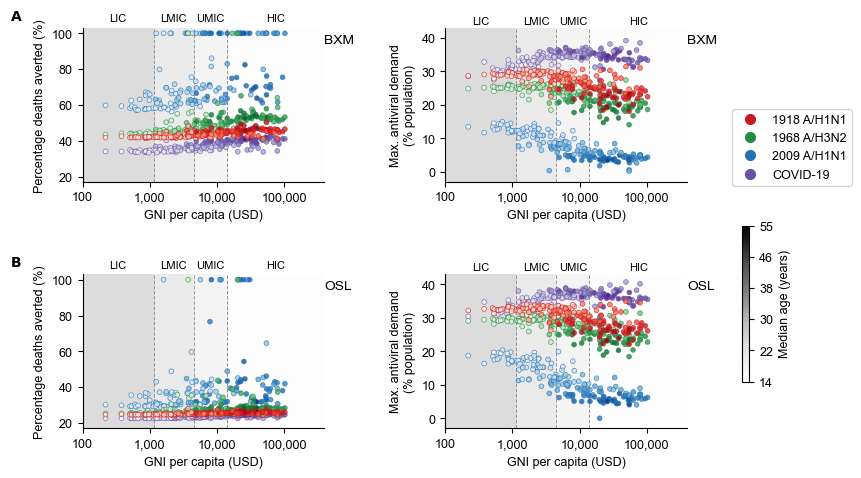

In [11]:
fig = plt.figure(figsize=(7.8, 10.4 * 0.5))
gs = GridSpec(nrows=2, ncols=2, hspace=0.6, wspace=0.5)

for r, treatment in enumerate(["BXM", "OSL"]):
    for y, ylabel in enumerate(['dea_averted_perc', 'av_stockpile_size']):
        ax = fig.add_subplot(gs[r,y])
        for p, pandemic in enumerate(["pandemic1918", "pandemic1968", "pandemic2009", "covid"]): 
            X = np.log10(plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)]['gdp'].to_numpy())
            Y = plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)][ylabel].to_numpy()
            # get cmap 
            Z = plot_df[(plot_df['treatment']==treatment)&(plot_df['pandemic']==pandemic)]['median_age'].to_numpy()
            vmin, vmax = Z.min(), Z.max()
            #cmap = sns.cubehelix_palette(as_cmap=True)
            cmap = sns.color_palette(["Reds", "Greens", "Blues", "Purples"][p], as_cmap=True)
    
            ax.scatter(X, Y, c=Z, cmap=cmap, s=12, edgecolors=['#cb181d','#238b45','#2171b5','#6a51a3'][p], linewidths=0.5, 
                       zorder=100 - p, alpha=0.75)
            
        xticks = np.linspace(2., 5., 4)
        ax.set_xticks(xticks)# (ax.get_yticks())
        ax.set_xticklabels(["{:,}".format(yv) for yv in np.int64(10**yticks)])
        ax.set_xlim(2., 5.6)
        if y == 0:
            ax.set_ylim(17,103)
        else: 
            ax.set_ylim(-3, 43)
        
        # cosmetics 
        for axis in ['top', 'right']:
            ax.spines[axis].set_visible(False)

        ax.set_xlabel("GNI per capita (USD)", fontsize=9)
        ax.set_ylabel(['Percentage deaths averted (%)', 'Max. antiviral demand\n(% population)'][y], fontsize=9)
        ax.tick_params(axis='both', labelsize=9)

        if y == 0:
            ax.text(x=-0.3, y=1.05, s=r'$\bf{%s}$'%(list(string.ascii_uppercase)[r]), transform=ax.transAxes, fontsize=10)
        ax.text(x=1., y=.9, s=treatment, fontsize=10, transform=ax.transAxes, ha='left')
        
        # LIC 
        # ['#ffffd4','#fed98e','#fe9929','#cc4c02']
        ax.axvline(x=np.log10(1145), lw=0.7, ls="--", zorder=-100, c='#929292')
        ax.text(y=ax.get_ylim()[1]*1.05, x=ax.get_xlim()[0] + (np.log10(1145) - ax.get_xlim()[0])*0.5, s="LIC", fontsize=8, 
                ha='center', va='center')
        ax.fill_betweenx(y=ax.get_ylim(), x1=ax.get_xlim()[0], x2=np.log10(1145), zorder=-100, fc='#525252', alpha=0.2)
        
        ax.axvline(x=np.log10(4515), lw=0.7, ls="--", zorder=-100, c='#929292')
        ax.text(y=ax.get_ylim()[1]*1.05, x=np.log10(1145) + (np.log10(4515) - np.log10(1145))*0.5, s="LMIC", fontsize=8, 
                ha='center', va='center')
        ax.fill_betweenx(y=ax.get_ylim(), x1=np.log10(1145), x2=np.log10(4515), zorder=-100, fc='#969696', alpha=0.2)
        
        ax.axvline(x=np.log10(14005), lw=0.7, ls="--", zorder=0, c='#929292')
        ax.text(y=ax.get_ylim()[1]*1.05, x=np.log10(4515) + (np.log10(14005) - np.log10(4515))*0.5, s="UMIC", fontsize=8, 
                ha='center', va='center')
        ax.fill_betweenx(y=ax.get_ylim(), x1=np.log10(4515), x2=np.log10(14005), zorder=-100, fc='#cccccc', alpha=0.2)
        
        ax.text(y=ax.get_ylim()[1]*1.05, x=np.log10(14005) + (ax.get_xlim()[-1] - np.log10(14005))*0.5, s="HIC", fontsize=8, 
                ha='center', va='center')
        ax.fill_betweenx(y=ax.get_ylim(), x1=np.log10(14005), x2=ax.get_xlim()[-1], zorder=-100, fc='#f7f7f7', alpha=0.2)
        
        
cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.3])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,)
cbar_ax.tick_params(labelsize=9)
yticks_arr = np.linspace(vmin, vmax, 6)
cbar_ax.set_yticks(yticks_arr)
cbar_ax.set_yticklabels(["%i"%(y) for y in yticks_arr])
cbar_ax.set_ylabel("Median age (years)", fontsize=9)

legend_handles = []
cmap = ['#cb181d','#238b45','#2171b5','#6a51a3']
for i, (col, label) in enumerate(zip(cmap, ["1918 A/H1N1", "1968 A/H3N2", "2009 A/H1N1", "COVID-19"])): 
    legend_handles.append(Line2D([0], [0], marker='o', color=col, 
                                 label=label, markerfacecolor=col, 
                                 lw=0, markersize=7))
fig.legend(handles=legend_handles, ncols=1, loc="center left", bbox_to_anchor=(.95, 0.65), fontsize=9)

plt.savefig("../manuscript/figure003.png", bbox_inches='tight', dpi=600)
plt.show()

## generate input table for bayesian hierarchical model 

In [12]:
# transform analysis_df 
analysis_df = tat_stockpile_df[(tat_stockpile_df["baseline"]==0)&(tat_stockpile_df['treatment'].isin(['BXM', 'BXM05-24', 'BXM25-64', 'BXM65-99']))].copy().reset_index()

#print (analysis_df[analysis_df['n_treatment_pep']>0])

for pandemic in ['pandemic1918', 'pandemic1968', 'pandemic2009', 'covid']: 
    pandemic_baseline_df = baseline_df[baseline_df['pandemic']==pandemic].copy().set_index("country")
    
    pandemic_indices = analysis_df[analysis_df['pandemic']==pandemic].index
    # get baseline deaths 
    analysis_df.loc[pandemic_indices, 'baseline_n_deaths'] = analysis_df.loc[pandemic_indices, "country"].map(pandemic_baseline_df['n_deaths']).to_numpy()
    # get baseline incidence 
    analysis_df.loc[pandemic_indices, 'baseline_n_incidence'] = analysis_df.loc[pandemic_indices, "country"].map(pandemic_baseline_df['n_wt']).to_numpy()

# compute perc incidence and deaths averted 
for label in ['n_incidence', 'n_deaths']: 
    baseline_values = analysis_df["baseline_" + label].to_numpy()
    analysis_values = analysis_df[label].to_numpy()
    
    averted_values = np.zeros(baseline_values.size)
    averted_values[baseline_values!=0] = 100 * (baseline_values[baseline_values!=0] - analysis_values[baseline_values!=0])/baseline_values[baseline_values!=0]
    analysis_df["perc_averted_" + label.replace("n_", "")] = averted_values
    
# AVS (7 days = baseline, 28 days = baseline + 3 weeks, 84 = baseline + 11 weeks) 
analysis_df['avs_week'] = analysis_df['AVS']#/365

# tat_d
analysis_df['tat_delay'] = analysis_df['tat_delay']#/365 

# treatment window 
analysis_df['treat_window_extended'] = 0
analysis_df.loc[analysis_df[analysis_df['treat_window']>2.].index, 'treat_window_extended'] = 1

# bxm resistance 
analysis_df.loc[analysis_df[analysis_df['bxm_resistance']==0].index, 'bxm_resistance_label'] = 'no_resist'
analysis_df.loc[analysis_df[analysis_df['bxm_resistance']==1].index, 'bxm_resistance_label'] = 'h1_resist'
analysis_df.loc[analysis_df[analysis_df['bxm_resistance']==2].index, 'bxm_resistance_label'] = 'h3_resist'

par_list = ['country', 'pandemic', 'avs_week', 'PEP', 'tat_delay', 'bxm_resistance_label', 'treat_window_extended', 'treatment', 'f_treatment', 'n_treatment_tat', 'n_treatment_pep', 'n_treatment'] #+ [treatment.replace("-", "") + "b" for treatment in ['BXM05-24', 'BXM25-64', 'BXM65-99']]
par_list += ['perc_averted_' + label for label in ['incidence', 'deaths']]
analysis_df = analysis_df[par_list]
#analysis_df[par_list].to_csv("../manuscript/bayesian_analysis_input.csv", index=False)
#analysis_df = pd.read_csv("../manuscript/bayesian_analysis_input.csv")
"""
for par in ['avs_week', 'PEP', 'tat_delay', 'bxm_resistance_label', 'treat_window_extended', 'treatment']:
    print (par, analysis_df[par].unique())
raise Exception
"""

reference_indices = []
for country in analysis_df['country'].unique(): 
    country_analysis_df = analysis_df[analysis_df["country"]==country].copy()

    for pandemic in country_analysis_df['pandemic'].unique(): 
        pandemic_country_analysis_df = country_analysis_df[country_analysis_df["pandemic"]==pandemic].copy()
        
        # reference idealized scenario - bxm_resistance_label = no_resist, treatment = BXM
        m1 = pandemic_country_analysis_df["bxm_resistance_label"] == "no_resist"
        m2 = pandemic_country_analysis_df["avs_week"] == 7.
        m3 = pandemic_country_analysis_df["PEP"] == 0.
        m4 = pandemic_country_analysis_df["tat_delay"] == 1.
        m5 = pandemic_country_analysis_df["treat_window_extended"] == 0.
        m6 = pandemic_country_analysis_df["treatment"] == "BXM"
        ref_scenario = pandemic_country_analysis_df[m1&m2&m3&m4&m5&m6].copy() 

        # incidence 
        ref_perc_averted_incidence = ref_scenario['perc_averted_incidence'].iloc[0]
        analysis_df.loc[pandemic_country_analysis_df.index, "perc_averted_incidence_norm"] = analysis_df.loc[pandemic_country_analysis_df.index, "perc_averted_incidence"] - ref_perc_averted_incidence

        # deaths 
        ref_perc_averted_deaths = ref_scenario['perc_averted_deaths'].iloc[0]
        analysis_df.loc[pandemic_country_analysis_df.index, "perc_averted_deaths_norm"] = analysis_df.loc[pandemic_country_analysis_df.index, "perc_averted_deaths"] - ref_perc_averted_deaths

        # f_treatment
        ref_f_treatment = ref_scenario['f_treatment'].iloc[0]
        analysis_df.loc[pandemic_country_analysis_df.index, "f_treatment_norm"] = analysis_df.loc[pandemic_country_analysis_df.index, "f_treatment"] - ref_f_treatment
        
        """
        ref_scenario = ref_scenario.set_index(["avs_week", "PEP", "tat_delay", "treat_window_extended"]).sort_index()
        for (avs_week, PEP, tat_delay, treat_window_extended) in pandemic_country_analysis_df.set_index(["avs_week", "PEP", "tat_delay", "treat_window_extended"]).index.unique(): 
            # reference values 
            ref_perc_averted_incidence = ref_scenario.loc[(avs_week, PEP, tat_delay, treat_window_extended), "perc_averted_incidence"]
            ref_perc_averted_deaths = ref_scenario.loc[(avs_week, PEP, tat_delay, treat_window_extended), "perc_averted_deaths"]
            # filter other scenarios 
            m2 = pandemic_country_analysis_df["avs_week"] == avs_week
            m3 = pandemic_country_analysis_df["PEP"] == PEP
            m4 = pandemic_country_analysis_df["tat_delay"] == tat_delay
            m5 = pandemic_country_analysis_df["treat_window_extended"] == treat_window_extended
            nonref_indices = pandemic_country_analysis_df[m2&m3&m4&m5].index

            analysis_df.loc[nonref_indices, "perc_averted_incidence_norm"] = analysis_df.loc[nonref_indices, "perc_averted_incidence"] - ref_perc_averted_incidence
            analysis_df.loc[nonref_indices, "perc_averted_deaths_norm"] = analysis_df.loc[nonref_indices, "perc_averted_deaths"] - ref_perc_averted_incidence
        """
        
# scale numerical values 
analysis_df['perc_averted_deaths_norm'] = analysis_df['perc_averted_deaths_norm']/100
analysis_df['perc_averted_incidence_norm'] = analysis_df['perc_averted_incidence_norm']/100
analysis_df['avs_week'] = analysis_df['avs_week']/365
analysis_df['tat_delay'] = analysis_df['tat_delay']/365
# remove reference scenarios 
#print (len(analysis_df))
#analysis_df = analysis_df[~analysis_df.index.isin(reference_indices)]
#print (len(analysis_df))
analysis_df.to_csv("../manuscript/bayesian_analysis_input.csv", index=False)
analysis_df.head()

,country,pandemic,avs_week,PEP,tat_delay,bxm_resistance_label,treat_window_extended,treatment,f_treatment,n_treatment_tat,n_treatment_pep,n_treatment,perc_averted_incidence,perc_averted_deaths,perc_averted_incidence_norm,perc_averted_deaths_norm,f_treatment_norm
0,USA,pandemic1918,0.019178,0.0,0.008219,h1_resist,0,BXM,0.232017,78189233,0,78189233,8.663489,28.223588,-0.083041,-0.178491,0.001082
1,USA,pandemic1918,0.019178,0.0,0.002740,h3_resist,1,BXM,0.274164,92392546,0,92392546,1.533741,4.814631,-0.154339,-0.412580,0.043228
2,USA,pandemic1918,0.019178,0.0,0.002740,h3_resist,0,BXM,0.273859,92289700,0,92289700,1.534624,4.814535,-0.154330,-0.412581,0.042923
3,USA,pandemic1918,0.019178,0.0,0.002740,h1_resist,0,BXM,0.263770,88889910,0,88889910,5.161837,15.495287,-0.118058,-0.305774,0.032835
4,USA,pandemic1918,0.019178,0.0,0.002740,h1_resist,1,BXM,0.264065,88989401,0,88989401,5.160511,15.499573,-0.118071,-0.305731,0.033130


## bayesian linear regression results

In [13]:
# result draws 
fixed_effect_draws = pd.read_csv("../manuscript/m1_fixed_effects.csv", index_col=0)
pandemic_re_draws = pd.read_csv("../manuscript/m1_re_pandemic.csv", index_col=0)
country_re_draws = pd.read_csv("../manuscript/m1_re_country.csv", index_col=0) 

av_fixed_effect_draws = pd.read_csv("../manuscript/av_m1_fixed_effects.csv", index_col=0)
av_pandemic_re_draws = pd.read_csv("../manuscript/av_m1_re_pandemic.csv", index_col=0)
av_country_re_draws = pd.read_csv("../manuscript/av_m1_re_country.csv", index_col=0) 

# y-sd 
y_sd = np.std(analysis_df['perc_averted_deaths_norm']) * 100
av_y_sd = np.std(analysis_df['f_treatment_norm'])

# zero-index 
fixed_effect_draws['.chain'] = fixed_effect_draws['.chain'] - 1
fixed_effect_draws['.iteration'] = fixed_effect_draws['.iteration'] - 1

pandemic_re_draws['.chain'] = pandemic_re_draws['.chain'] - 1
pandemic_re_draws['.iteration'] = pandemic_re_draws['.iteration'] - 1

av_fixed_effect_draws['.chain'] = av_fixed_effect_draws['.chain'] - 1
av_fixed_effect_draws['.iteration'] = av_fixed_effect_draws['.iteration'] - 1

av_pandemic_re_draws['.chain'] = av_pandemic_re_draws['.chain'] - 1
av_pandemic_re_draws['.iteration'] = av_pandemic_re_draws['.iteration'] - 1

In [14]:
def hpd_grid(sample, alpha=0.05):
    
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(min(hdv))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(hdv[i-1])
            hpd.append(hdv[i])
    hpd.append(max(hdv))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(x_hpd[np.argmax(y_hpd)])
    
    return hpd, density, modes

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc

def colored_line_between_pts(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified between (x, y) points by a third value.

    It does this by creating a collection of line segments between each pair of
    neighboring points. The color of each segment is determined by the
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should have a size one less than that of x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Check color array size (LineCollection still works, but values are unused)
    if len(c) != len(x) - 1:
        warnings.warn(
            "The c argument should have a length one less than the length of x and y. "
            "If it has the same length, use the colored_line function instead."
        )
    """

    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, **lc_kwargs)

    # Set the values used for colormapping
    lc.set_array(c)

    return ax.add_collection(lc)

## Figure 4: Joint effects of treatment delays, distribution strategies, post-exposure prophylaxis and antiviral resistance on average percentage deaths averted and baloxavir marboxil (BXM) demand.

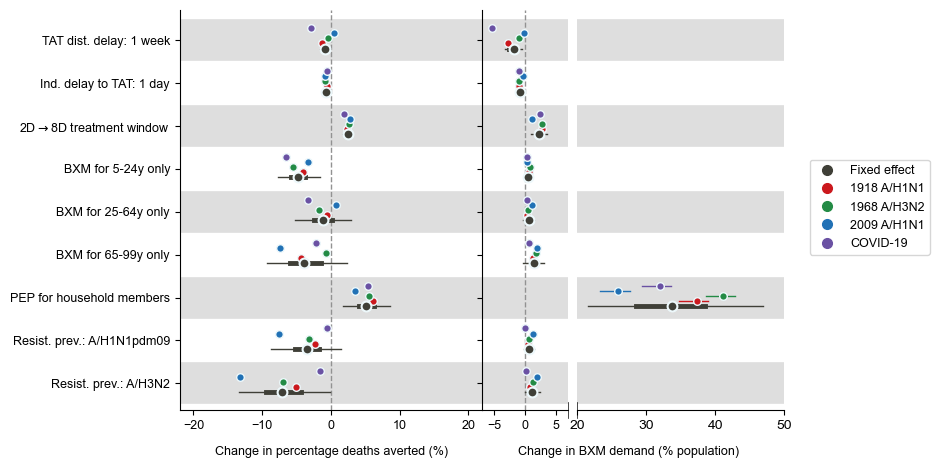

In [15]:
fig = plt.figure(figsize=(7.8, 10.4 * 0.5))
gs = GridSpec(nrows=1, ncols=4, wspace=0., width_ratios=[0.5, 0.1425, 0.015, 0.3425])

fixed_pars = ['avs_week_1', 
              'tat_delay_1',
              'treat_window_extended', 
              'treat_bxm0524', 
              'treat_bxm2564', 
              'treat_bxm6599', 
              'PEP',
              'bxm_resist_h1', 
              'bxm_resist_h3']

fixed_par_labels = ['TAT dist. delay: 1 week',
                    'Ind. delay to TAT: 1 day',
                    #'Ind. delay to TAT: 4 days',
                    '2D' + r'$\to$' +  '8D treatment window', 
                    'BXM for 5-24y only', 
                    'BXM for 25-64y only', 
                    'BXM for 65-99y only', 
                    'PEP for household members', 
                    'Resist. prev.: A/H1N1pdm09', 
                    'Resist. prev.: A/H3N2']

ax22 = fig.add_subplot(gs[3])
for axi in range(2): 
    #print (axi)
    ax = fig.add_subplot(gs[axi])
    
    for yi, par in enumerate(fixed_pars[::-1]): # + ["Intercept"] 
        if re.search("tat_delay", par): 
            delta_t = float(re.search("[0-9]+$", par).group())
            par = "tat_delay"
        elif re.search("avs_week", par): 
            delta_t = float(re.search("[0-9]+$", par).group())
            par = "avs_week"
            
        ## -- Fixed effects -- ## 
        if axi > 0: 
            posterior_intercept = av_fixed_effect_draws['b_Intercept'].copy().to_numpy()
            posterior_draws = av_fixed_effect_draws["b_%s"%(par)].copy().to_numpy() #+ posterior_intercept
            posterior_draws *= av_y_sd # denormalize  
        else: 
            posterior_intercept = fixed_effect_draws['b_Intercept'].copy().to_numpy()
            posterior_draws = fixed_effect_draws["b_%s"%(par)].copy().to_numpy() #+ posterior_intercept
            posterior_draws *= y_sd # denormalize  
        
        
        if par == "tat_delay": # convert to per-day 
            posterior_draws /= (365/delta_t)
        elif par == "avs_week": # convert to per-week
            posterior_draws /= (365/(delta_t*7))
        if axi > 0: 
            posterior_draws *= 100
    
        # get mode and 95% hpd 
        hpd, density, modes = hpd_grid(posterior_draws, alpha=0.05)
        # plot mode scatter 
        mu = modes[0]
        
        if axi > 0 and par == "PEP": 
            ax22.scatter([mu], [yi-0.2], s=50, marker="o", c='#3F3F37', edgecolors="#edf8fb", lw=1.5, zorder=100)
        else:
            ax.scatter([mu], [yi-0.2], s=50, marker="o", c='#3F3F37', edgecolors="#edf8fb", lw=1.5, zorder=100)

        # get 67% hpd 
        hpd67 = hpd_grid(posterior_draws, alpha=0.33)[0]

        #print (par, "%.1f (%.1f - %.1f)"%(mu, hpd[0][0], hpd[0][1]))
        
        # plot HPDs 
        if axi > 0 and par == "PEP": 
            ax22.plot([hpd[0][0], hpd[0][1]], [yi-0.2]*2, lw=1., c="#3F3F37", zorder=91)
            ax22.plot([hpd67[0][0], hpd67[0][1]], [yi-0.2]*2, lw=3.5, c="#3F3F37", zorder=91)
        else: 
            ax.plot([hpd[0][0], hpd[0][1]], [yi-0.2]*2, lw=1., c="#3F3F37", zorder=91)
            ax.plot([hpd67[0][0], hpd67[0][1]], [yi-0.2]*2, lw=3.5, c="#3F3F37", zorder=91)
    
        if yi%2 == 0: 
            ax.axhline(yi, c="#929292", lw=30., alpha=0.3, zorder=-100)
            if axi > 0: 
                ax22.axhline(yi, c="#929292", lw=30., alpha=0.3, zorder=-100)
            
        ## -- Random effects: pandemic -- ## 
        for pi, (pandemic, pcol) in enumerate(zip(["pandemic1918", "pandemic1968", "pandemic2009", "covid"], 
                                                  ['#cb181d','#238b45','#2171b5','#6a51a3'])): 

            if axi > 0: 
                pandemic_draws = av_pandemic_re_draws[(av_pandemic_re_draws["term"]==par)&(av_pandemic_re_draws["condition"]==pandemic)]["r_pandemic"].to_numpy()
                pandemic_draws *= (av_y_sd) # denormalize  
            else:
                pandemic_draws = pandemic_re_draws[(pandemic_re_draws["term"]==par)&(pandemic_re_draws["condition"]==pandemic)]["r_pandemic"].to_numpy()
                pandemic_draws *= (y_sd) # denormalize  
            
            if par == "tat_delay": # convert to per-day 
                pandemic_draws /= (365/delta_t)
            elif par == "avs_week": # convert to per-week
                pandemic_draws /= (365/(delta_t*7))
            if axi > 0: 
                pandemic_draws *= 100
            pandemic_draws = pandemic_draws + posterior_draws
            
            pandemic_hpd, pandemic_kde_density, pandemic_modes = hpd_grid(pandemic_draws, alpha=.05)
            
            #ax.fill_between(x=xx, y1=[yi]*yy2.size, y2=yy2, fc=pcol, alpha=0.7, zorder=90)
            if axi > 0 and par == "PEP": 
                ax22.scatter([pandemic_modes[0]], [yi - 0.2 + (pi+1)*0.12], s=30, marker="o", c=pcol, edgecolors="#edf8fb", lw=1., zorder=92)
                ax22.plot([pandemic_hpd[0][0], pandemic_hpd[0][1]], [yi - 0.2 + (pi+1)*0.12]*2, lw=1., c=pcol, zorder=91)
            else: 
                ax.scatter([pandemic_modes[0]], [yi - 0.2 + (pi+1)*0.12], s=30, marker="o", c=pcol, edgecolors="#edf8fb", lw=1., zorder=92)
                ax.plot([pandemic_hpd[0][0], pandemic_hpd[0][1]], [yi - 0.2 + (pi+1)*0.12]*2, lw=1., c=pcol, zorder=91)
                
            #ax.plot(xx, yy-0.2, lw=5., c=pcol, zorder=95, alpha=0.7)
            #print (pandemic, "%.1f (%.1f - %.1f)"%(pandemic_modes[0], pandemic_hpd[0][0], pandemic_hpd[0][1]))
            """
            density_y = density(np.linspace(ll, ul, 201))
            density_y = 0.5 * (density_y/density_y.max()) + yi + 0.12
            """
            
    ax.axvline(0., lw=1., ls='--', c='#929292', zorder=0)
    for axis in ["top", "right"]:
        ax.spines[axis].set_visible(False)
        if axi > 0:
            ax22.spines[axis].set_visible(False)
        
    ax.set_yticks(np.arange(len(fixed_pars)))
    if axi == 0: 
        ax.set_yticklabels(fixed_par_labels[::-1])
        ax.set_xlim(-22, 22)
    else: 
        ax.set_yticklabels([])
        ax.set_xlim(-7, 7)
        ax22.set_xlim(20, 50)
        #ax.text(x=1., y=0., , fontsize=9, transform=ax.transAxes)
        ax22.set_ylim(ax.get_ylim())
        ax22.set_yticklabels([])
        ax22.tick_params(axis='y', left=None)
        
        ax.spines['right'].set_visible(False)
        ax22.spines['left'].set_visible(False)
        
        d = .02 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth=.5)
        ax.plot((1,1),(-d,+d), **kwargs) # top-left diagonal
        
        kwargs.update(transform=ax22.transAxes) # switch to the bottom axes
        ax22.plot((0,0),(-d,+d), **kwargs) # top-right diagonal
        
    ax.tick_params(axis='both', labelsize=9)

legend_handles = []
for label, col in zip(["Fixed effect", "1918 A/H1N1", "1968 A/H3N2", "2009 A/H1N1", "COVID-19"], 
                      ['#3F3F37', '#cb181d','#238b45','#2171b5','#6a51a3', ]): 
    legend_handles.append(Line2D([0], [0], marker='o', color=col, 
                                 label=label, markerfacecolor=col, 
                                 lw=0., markersize=7))
fig.legend(handles=legend_handles, ncols=1, loc="center left", bbox_to_anchor=(0.925, 0.5), fontsize=9)

fig.text(x=0.32, y=0.03, s="Change in percentage deaths averted (%)", fontsize=9, ha='center', va='center')
fig.text(x=0.7, y=0.03, s="Change in BXM demand (% population)", fontsize=9, ha='center', va='center')
plt.savefig("../manuscript/figure004.png", bbox_inches='tight', dpi=600)
plt.show()

## Country-level effects

In [16]:
country_list = sorted(country_re_draws['condition'].unique())
country_re_draws.head()

,condition,term,r_country,.chain,.iteration,.draw
1,AFG,avs_week,1.53786,1,1,1
2,AFG,avs_week,1.68124,1,2,2
3,AFG,avs_week,1.49910,1,3,3
4,AFG,avs_week,1.52602,1,4,4
5,AFG,avs_week,1.85260,1,5,5


In [17]:
def worker(axi, par, country):
    
    if re.search("tat_delay", par): 
        delta_t = float(re.search("[0-9]+$", par).group())
        par = "tat_delay"
    elif re.search("avs_week", par): 
        delta_t = float(re.search("[0-9]+$", par).group())
        par = "avs_week"
        
    ## -- Fixed effects -- ## 
    if axi > 0: 
        posterior_intercept = av_fixed_effect_draws['b_Intercept'].copy().to_numpy()
        posterior_draws = av_fixed_effect_draws["b_%s"%(par)].copy().to_numpy() #+ posterior_intercept
        posterior_draws *= av_y_sd # denormalize  
    else: 
        posterior_intercept = fixed_effect_draws['b_Intercept'].copy().to_numpy()
        posterior_draws = fixed_effect_draws["b_%s"%(par)].copy().to_numpy() #+ posterior_intercept
        posterior_draws *= y_sd # denormalize  

    if par == "tat_delay": # convert to per-day 
        posterior_draws /= (365/delta_t)
    elif par == "avs_week": # convert to per-week
        posterior_draws /= (365/(delta_t*7))
    if axi > 0: 
        posterior_draws *= 100

    if axi > 0: 
        country_draws = av_country_re_draws[(av_country_re_draws["term"]==par)&(av_country_re_draws["condition"]==country)]['r_country'].to_numpy()
        country_draws *= (av_y_sd) # denormalize 
    else: 
        country_draws = country_re_draws[(country_re_draws["term"]==par)&(country_re_draws["condition"]==country)]["r_country"].to_numpy()
        country_draws *= (y_sd) # denormalize 
    
    if par == "tat_delay": # convert to per-day 
        country_draws /= (365/delta_t)
    elif par == "avs_week": # convert to per-week
        country_draws /= (365/(delta_t*7))

    if axi > 0: 
        country_draws *= 100
    
    country_draws = country_draws + posterior_draws
    
    country_hpd, country_kde_density, country_modes = hpd_grid(country_draws, alpha=.05)

    hpd_l, hpd_r = country_hpd[0][0], country_hpd[0][1]
    if (hpd_l > 0 and hpd_r > 0) or (hpd_l < 0 and hpd_r < 0): 
        non_trivial = 1
    else: 
        non_trivial = 0

    row = {"country":country, "target":"demand" if axi > 0 else "impact", 
           "par":par, "mean":country_modes[0], "hpd_l":hpd_l, "hpd_r":hpd_r, 
           "non_trivial":non_trivial}
    print (row)
    return row

In [18]:
try: 
    country_effect_summary = pd.read_csv("../manuscript/country_effect_summary_conly.csv")
except: 
    worker_list = []
    for axi in range(2): 
        for yi, par in enumerate(fixed_pars[::-1]): 
            ## -- Random effects: country -- ## 
            for ci, country in enumerate(country_list): 
                worker_list.append((axi, par, country))
    print (len(worker_list))
    
    with mp.Pool(processes=6) as pool: 
        results = [pool.apply_async(worker, args=(axi, par, country,)) for (axi, par, country) in worker_list]
        country_effect_summary = [p.get() for p in results]

    country_effect_summary = pd.DataFrame.from_dict(country_effect_summary)
    country_effect_summary.to_csv("../manuscript/country_effect_summary.csv", index=False)

country_effect_summary.head()

,country,target,par,mean,hpd_l,hpd_r,non_trivial,gni,median_age
0,AFG,impact,bxm_resist_h3,-2.366239,-3.221576,-1.604928,1,380.0,16.8
1,AGO,impact,bxm_resist_h3,-1.189116,-2.008383,-0.386174,1,2120.0,16.4
2,ALB,impact,bxm_resist_h3,-0.437397,-1.363302,0.346061,0,7680.0,35.9
3,ARE,impact,bxm_resist_h3,-1.456267,-2.241747,-0.546842,1,49020.0,30.9
4,ARG,impact,bxm_resist_h3,-1.008210,-1.828386,-0.209538,1,12890.0,31.7


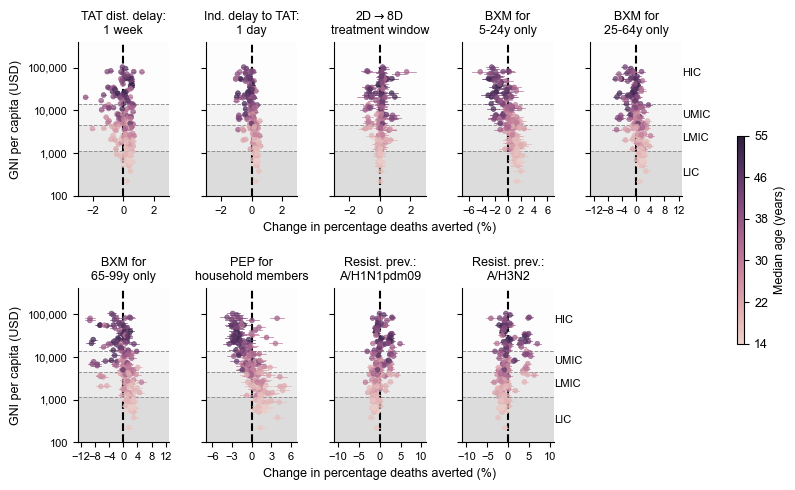

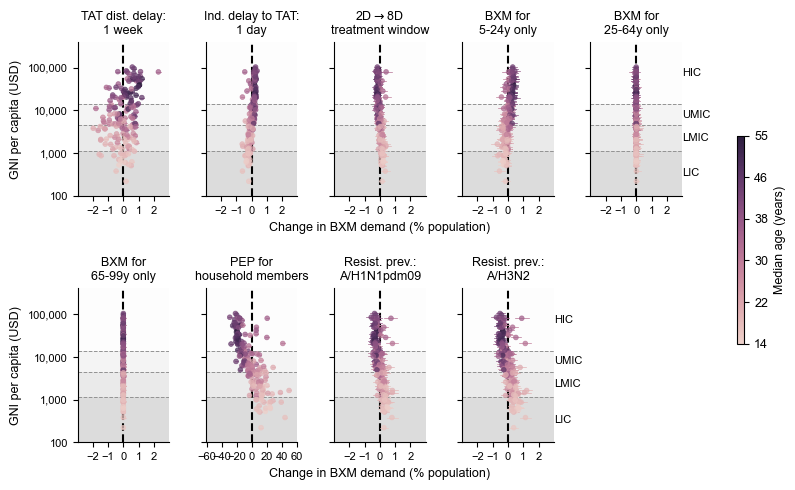

In [19]:
country_effect_summary['gni'] = country_effect_summary['country'].map(gdp_data['GNI_2023'])
country_effect_summary['median_age'] = country_effect_summary['country'].map(pop_data['median_age'])
country_effect_summary['pop_N'] = country_effect_summary['country'].map(tat_stockpile_df[['country', 'pop_N']].copy().drop_duplicates().set_index('country')['pop_N'])    
country_effect_summary['pop_N'] = np.log10(country_effect_summary['pop_N'])

fixed_par_labels = ['TAT dist. delay:\n1 week',
                    'Ind. delay to TAT:\n1 day',
                    #'Ind. delay to TAT: 4 days',
                    '2D' + r'$\to$' +  '8D\ntreatment window', 
                    'BXM for\n5-24y only', 
                    'BXM for\n25-64y only', 
                    'BXM for\n65-99y only', 
                    'PEP for\nhousehold members', 
                    'Resist. prev.:\nA/H1N1pdm09', 
                    'Resist. prev.:\nA/H3N2']

for figlabel, target in zip(["figureS02", "figureS04"], ['impact', 'demand']): 
    target_country_effect_summary = country_effect_summary[country_effect_summary['target']==target].copy()
    #target_country_effect_summary = target_country_effect_summary[target_country_effect_summary['non_trivial']>0]

    fig = plt.figure(figsize=(7.8, 10.4*0.5))
    gs = GridSpec(nrows=2, ncols=5, wspace=0.4, hspace=0.6)

    for yi, par in enumerate(fixed_pars): 
        
        if re.search("tat_delay", par): 
            par = "tat_delay"
        elif re.search("avs_week", par): 
            par = "avs_week"
            
        ax = fig.add_subplot(gs[yi])
        
        Y = np.log10(target_country_effect_summary[target_country_effect_summary['par']==par]['gni'].to_numpy())
        X = target_country_effect_summary[target_country_effect_summary['par']==par]['mean'].to_numpy()
        Z = target_country_effect_summary[target_country_effect_summary['par']==par]['median_age'].to_numpy()

        HPD_l = target_country_effect_summary[target_country_effect_summary['par']==par]['hpd_l'].to_numpy()
        HPD_r = target_country_effect_summary[target_country_effect_summary['par']==par]['hpd_r'].to_numpy()
        
        vmin, vmax = Z.min(), Z.max()        
        ax.scatter(X, Y, c=Z, cmap=sns.cubehelix_palette(as_cmap=True), s=12, linewidths=0.5, 
                   zorder=100, alpha=0.75)

        sm = ScalarMappable(norm=Normalize(vmin=vmin, 
                                   vmax=vmax), 
                    cmap=sns.cubehelix_palette(as_cmap=True))
        for ci in range(X.size):
            ax.plot([HPD_l[ci], HPD_r[ci]], [Y[ci]]*2, lw=0.5, c=sm.to_rgba(Z)[ci], zorder=99)
        #ax.errorbar(X, Y, c=sns.cubehelix_palette(as_cmap=True, vmin=vmin, vmax=vmax), s=12, linewidths=0.5, zorder=100, alpha=0.75)

        yticks = np.linspace(2., 5., 4)
        ax.set_yticks(yticks)# (ax.get_yticks())
        if yi%5 == 0:
            ax.set_yticklabels(["{:,}".format(yv) for yv in np.int64(10**yticks)])
            ax.set_ylabel("GNI per capita (USD)", fontsize=9)
        else: 
            ax.set_yticklabels([])
        ax.set_ylim(2., 5.6)
        ax.set_title(fixed_par_labels[yi], fontsize=9)
        
        # cosmetics 
        for axis in ['top', 'right']:
            ax.spines[axis].set_visible(False)
        ax.tick_params(axis='both', labelsize=8)

        
        target_xlim = [(-3, 3), (-3, 3), (-3, 3), (-7, 7), (-13, 13), 
                       (-13, 13), (-7, 7), (-11, 11), (-11, 11)]
        target_xticks_sep = [2, 2, 2, 2, 4, 4, 3, 5, 5]

        demand_xlim = [(-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), 
                       (-3, 3), (-61, 61), (-3, 3), (-3, 3)]
        demand_xticks_sep = [1, 1, 1, 1, 1, 1, 20, 1, 1]
        
        if target == 'impact':
            try:
                ax.set_xlim(target_xlim[yi])
                xticks = list(np.arange(target_xlim[yi][0]+1, target_xlim[yi][1], target_xticks_sep[yi]))
                if 0 not in xticks: 
                    xticks = sorted(xticks + [0])
                ax.set_xticks(xticks)
            except: 
                pass 
        else: 
            try:
                ax.set_xlim(demand_xlim[yi])
                xticks = list(np.arange(demand_xlim[yi][0]+1, demand_xlim[yi][1], demand_xticks_sep[yi]))
                if 0 not in xticks: 
                    xticks = sorted(xticks + [0])
                ax.set_xticks(xticks)
            except: 
                pass 
        
        # LIC 
        # ['#ffffd4','#fed98e','#fe9929','#cc4c02']
        ax.axhline(y=np.log10(1145), lw=0.7, ls="--", zorder=0, c='#929292')
        if yi in [4, 8]:
            ax.text(x=ax.get_xlim()[1], y=ax.get_ylim()[0] + (np.log10(1145) - ax.get_ylim()[0])*0.5, s="LIC", fontsize=8, ha='left', va='center')
        ax.fill_between(x=ax.get_xlim(), y1=ax.get_ylim()[0], y2=np.log10(1145), zorder=-100, fc='#525252', alpha=0.2)
        
        ax.axhline(y=np.log10(4515), lw=0.7, ls="--", zorder=0, c='#929292')
        if yi in [4, 8]:
            ax.text(x=ax.get_xlim()[1], y=np.log10(1145) + (np.log10(4515) - np.log10(1145))*0.5, s="LMIC", fontsize=8, ha='left', va='center')
        ax.fill_between(x=ax.get_xlim(), y1=np.log10(1145), y2=np.log10(4515), zorder=-100, fc='#969696', alpha=0.2)
        
        ax.axhline(y=np.log10(14005), lw=0.7, ls="--", zorder=0, c='#929292')
        if yi in [4, 8]:
            ax.text(x=ax.get_xlim()[1], y=np.log10(4515) + (np.log10(14005) - np.log10(4515))*0.5, s="UMIC", fontsize=8, ha='left', va='center')
        ax.fill_between(x=ax.get_xlim(), y1=np.log10(4515), y2=np.log10(14005), zorder=-100, fc='#cccccc', alpha=0.2)

        if yi in [4, 8]:
            ax.text(x=ax.get_xlim()[1], y=np.log10(14005) + (ax.get_ylim()[-1] - np.log10(14005))*0.5, s="HIC", fontsize=8, ha='left', va='center')
        ax.fill_between(x=ax.get_xlim(), y1=np.log10(14005), y2=ax.get_ylim()[-1], zorder=-100, fc='#f7f7f7', alpha=0.2)


        ax.axvline(x=0., zorder=-99, lw=1.5, ls='--', c='k')
        if yi in [2, 7]: 
            ax.set_xlabel("Change in percentage deaths averted (%)" if target == "impact" else "Change in BXM demand (% population)", 
                          fontsize=9)

    cmap = sns.cubehelix_palette(as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.97, 0.3, 0.01, 0.4])
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,)
    cbar_ax.tick_params(labelsize=9)
    yticks_arr = np.linspace(vmin, vmax, 6)
    cbar_ax.set_yticks(yticks_arr)
    cbar_ax.set_yticklabels(["%i"%(y) for y in yticks_arr])
    cbar_ax.set_ylabel("Median age (years)", fontsize=9)

    plt.savefig("../manuscript/%s.png"%(figlabel), bbox_inches='tight', dpi=300)
    plt.show()
    #raise Exception

0.7973061234602533
4.000403948504515


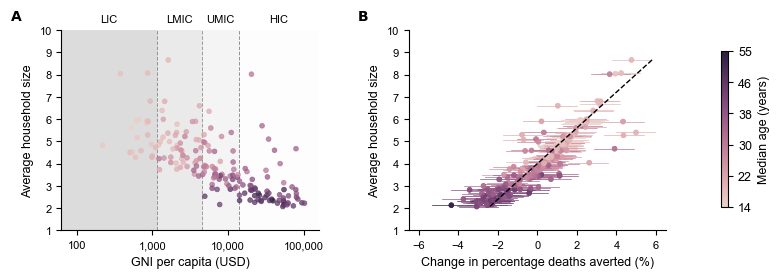

In [20]:
from scipy.stats import linregress
# get average household size 
hh_data = pd.read_excel("../data/undesa_pd_2022_hh-size-composition.xlsx")
hh_data = hh_data[hh_data["Average household size (number of members)"] != ".."]

country_iso_codes_df = pd.read_csv("../data/country_iso_codes.csv")
country_effect_summary['country_iso'] = country_effect_summary['country'].map(country_iso_codes_df.set_index("alpha-3")['country-code'])
iso_to_country = country_effect_summary[['country', 'country_iso']].copy().drop_duplicates().set_index('country_iso').to_dict()['country']

country_to_avg_hh_size = {country:np.float32(hh_data[hh_data["ISO Code"]==iso].sort_values(by="Reference date (dd/mm/yyyy)", ascending=False)['Average household size (number of members)'].iloc[0]) for iso, country in iso_to_country.items()}

country_effect_summary['avg_hh_size'] = country_effect_summary['country'].map(country_to_avg_hh_size)

country_info_df = country_effect_summary[['country', 'avg_hh_size', 'median_age', 'gni']].copy().drop_duplicates()

# plt GNI against avg hh size 
fig = plt.figure(figsize=(7.8, 10.4*0.25))
gs = GridSpec(nrows=1, ncols=2, wspace=0.35)

ax = fig.add_subplot(gs[0])

X = np.log10(country_info_df['gni'].to_numpy())
Y = country_info_df['avg_hh_size'].to_numpy()
Z = country_info_df['median_age'].to_numpy()

vmin, vmax = Z.min(), Z.max()        
ax.scatter(X, Y, c=Z, cmap=sns.cubehelix_palette(as_cmap=True), s=12, linewidths=0.5, 
           zorder=100, alpha=0.75)

xticks = np.linspace(2., 5., 4)
ax.set_xlim(1.8, 5.2)
ax.set_xticks(xticks)# (ax.get_yticks())
ax.set_xticklabels(["{:,}".format(xv) for xv in np.int64(10**xticks)])
ax.set_xlabel("GNI per capita (USD)", fontsize=9)
ax.set_ylim(1., 10.)
ax.set_ylabel("Average household size", fontsize=9)

ax.axvline(x=np.log10(1145), lw=0.7, ls="--", zorder=-100, c='#929292')
ax.text(y=ax.get_ylim()[1]*1.05, x=ax.get_xlim()[0] + (np.log10(1145) - ax.get_xlim()[0])*0.5, s="LIC", fontsize=8, 
        ha='center', va='center')
ax.fill_betweenx(y=ax.get_ylim(), x1=ax.get_xlim()[0], x2=np.log10(1145), zorder=-100, fc='#525252', alpha=0.2)

ax.axvline(x=np.log10(4515), lw=0.7, ls="--", zorder=-100, c='#929292')
ax.text(y=ax.get_ylim()[1]*1.05, x=np.log10(1145) + (np.log10(4515) - np.log10(1145))*0.5, s="LMIC", fontsize=8, 
        ha='center', va='center')
ax.fill_betweenx(y=ax.get_ylim(), x1=np.log10(1145), x2=np.log10(4515), zorder=-100, fc='#969696', alpha=0.2)

ax.axvline(x=np.log10(14005), lw=0.7, ls="--", zorder=0, c='#929292')
ax.text(y=ax.get_ylim()[1]*1.05, x=np.log10(4515) + (np.log10(14005) - np.log10(4515))*0.5, s="UMIC", fontsize=8, 
        ha='center', va='center')
ax.fill_betweenx(y=ax.get_ylim(), x1=np.log10(4515), x2=np.log10(14005), zorder=-100, fc='#cccccc', alpha=0.2)

ax.text(y=ax.get_ylim()[1]*1.05, x=np.log10(14005) + (ax.get_xlim()[-1] - np.log10(14005))*0.5, s="HIC", fontsize=8, 
        ha='center', va='center')
ax.fill_betweenx(y=ax.get_ylim(), x1=np.log10(14005), x2=ax.get_xlim()[-1], zorder=-100, fc='#f7f7f7', alpha=0.2)

ax.tick_params(axis='both', labelsize=8)

for axis in ['top', 'right']:
    ax.spines[axis].set_visible(False)
ax.text(x=-0.2, y=1.05, s=r'$\bf{%s}$'%("A"), transform=ax.transAxes, fontsize=10)

## plt turn around
ax = fig.add_subplot(gs[1])
for axis in ['top', 'right']:
    ax.spines[axis].set_visible(False)

plot_df = country_effect_summary[(country_effect_summary['par']=='PEP')&(country_effect_summary['target']=='impact')]
X = plot_df['mean'].to_numpy()
Y = plot_df['avg_hh_size'].to_numpy()
Z = plot_df['median_age'].to_numpy()
HPD_l = plot_df['hpd_l'].to_numpy()
HPD_r = plot_df['hpd_r'].to_numpy()

ax.scatter(X, Y, c=Z, cmap=sns.cubehelix_palette(as_cmap=True), s=12, linewidths=0.5, 
           zorder=100, alpha=0.75)

vmin, vmax = Z.min(), Z.max()        
ax.scatter(X, Y, c=Z, cmap=sns.cubehelix_palette(as_cmap=True), s=12, linewidths=0.5, 
           zorder=100, alpha=0.75)

sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
            cmap=sns.cubehelix_palette(as_cmap=True))
for ci in range(X.size):
    ax.plot([HPD_l[ci], HPD_r[ci]], [Y[ci]]*2, lw=0.5, c=sm.to_rgba(Z)[ci], zorder=99)

lr = linregress(Y, X)
print (lr.rvalue**2)
xx = np.linspace(Y.min(), Y.max(), 100)
yy = lr.slope*xx + lr.intercept
print (xx[yy>0][0])
ax.plot(yy, xx, zorder=101, c='k', ls='--', lw=1.)

ax.set_ylim(1., 10.)
ax.set_yticks(np.linspace(1., 10., 10))
ax.set_ylabel("Average household size", fontsize=9)
ax.set_xlim(-6.5, 6.5)
ax.set_xlabel("Change in percentage deaths averted (%)", fontsize=9)
ax.tick_params(axis='both', labelsize=8)
ax.text(x=-0.2, y=1.05, s=r'$\bf{%s}$'%("B"), transform=ax.transAxes, fontsize=10)

cmap = sns.cubehelix_palette(as_cmap=True)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.6])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,)
cbar_ax.tick_params(labelsize=9)
yticks_arr = np.linspace(vmin, vmax, 6)
cbar_ax.set_yticks(yticks_arr)
cbar_ax.set_yticklabels(["%i"%(y) for y in yticks_arr])
cbar_ax.set_ylabel("Median age (years)", fontsize=9)

plt.savefig("../manuscript/figures03.png", bbox_inches='tight', dpi=300)
plt.show()
    